In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

%matplotlib inline
import matplotlib.pyplot as plt

# Read in Raw Data

In [3]:
TRAIN_DATA_PATH = '../data/commute-times-train.csv'
TEST_DATA_PATH = '../data/commute-times-test.csv'

In [49]:
train_data_raw = pd.read_csv(TRAIN_DATA_PATH, 
                             parse_dates=['time_of_day_ts'])
test_data_raw = pd.read_csv(TEST_DATA_PATH,
                            parse_dates=['time_of_day_ts'])

In [50]:
train_data_raw['dataset'] = 'TRAIN'
test_data_raw['dataset'] = 'TEST'

raw_data = pd.concat([train_data_raw, test_data_raw])

In [51]:
raw_data.head()

,Unnamed: 0,source_latitude,source_longitude,destination_latitude,destination_longitude,time_of_day_ts,commute_type,commute_time,dataset
0,0,-0.182809,0.361579,0.485623,0.300347,2018-08-13 16:56:00,BUS,25.156297,TRAIN
1,1,0.160297,0.064330,0.702545,-0.116307,2018-08-13 18:19:00,CAR,12.937429,TRAIN
2,2,0.762229,0.486693,0.197252,0.790051,2018-08-13 17:36:00,BIKE,29.013729,TRAIN
3,3,0.187947,0.508487,-0.372924,-0.914006,2018-08-13 07:41:00,CAR,18.215423,TRAIN
4,4,-0.431013,-0.600620,0.729273,0.215633,2018-08-13 15:56:00,TRAIN,11.196802,TRAIN


# Raw Data (One Variable) Visualizations

Text(0.5,1,'Destination Of Commute Lat, Long')

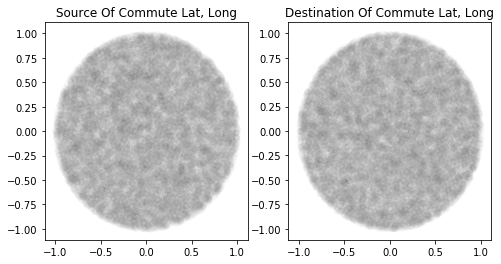

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].scatter(train_data_raw['source_latitude'],
               train_data_raw['source_longitude'],
               color="grey", alpha=0.02)
axs[0].set_title("Source Of Commute Lat, Long")
axs[1].scatter(train_data_raw['destination_latitude'],
               train_data_raw['destination_longitude'],
               color="grey", alpha=0.02)
axs[1].set_title("Destination Of Commute Lat, Long")

Text(0,0.5,'Volume of Commutes')

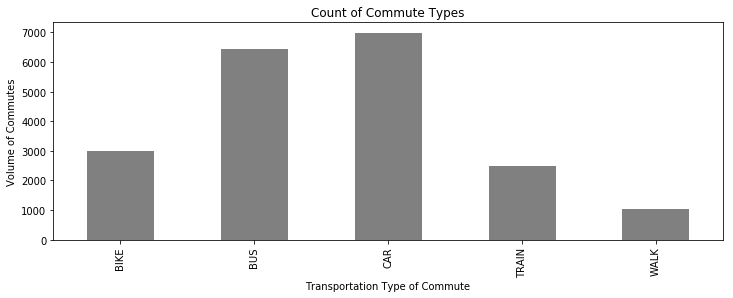

In [63]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw.groupby('commute_type').size().plot(
    ax=ax, kind='bar', color="grey")
ax.set_title("Count of Commute Types")
ax.set_xlabel("Transportation Type of Commute")
ax.set_ylabel("Volume of Commutes")

Text(0,0.5,'Volume of Commutes')

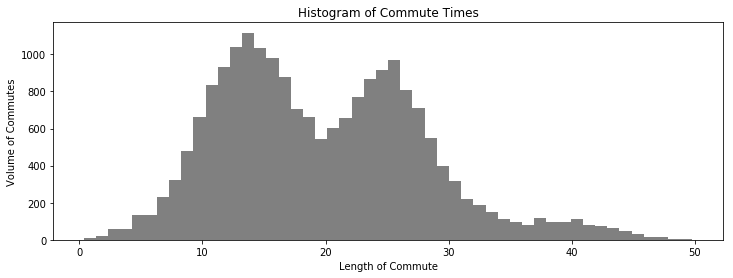

In [62]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw['commute_time'].plot(
    ax=ax, kind='hist', bins=50, color="grey")
ax.set_title("Histogram of Commute Times")
ax.set_xlabel("Length of Commute")
ax.set_ylabel("Volume of Commutes")

We'd like to draw a histogram of time of day, but this is not easy to do on the raw timestamp data.  To make our lives easy, we'll convert this into a decimal between zero and twenty-four.

**Discussion.**

Discuss multi-modal nature.  What could be causing that?  **A:** We may have different subpopulations in the data with different commute time behaviour, transportation type is a possibility.

In [57]:
def timestamp_to_decimal(ts):
    """Convert a timestamp datum into a decimal between zero and twenty-four.
    
    Parameters
    ----------
    ts: pd.Series of datetime.
    """
    return ts.dt.hour + (1/60)*ts.dt.minute

train_data_raw['time_of_day'] = timestamp_to_decimal(
    train_data_raw['time_of_day_ts'])
test_data_raw['time_of_day'] = timestamp_to_decimal(
    test_data_raw['time_of_day_ts'])

Notice how we have to apply the **same transformation** to our training and testing data.  I'll show you a trick soon that will save us some trouble.

Text(0,0.5,'Volume of Commutes')

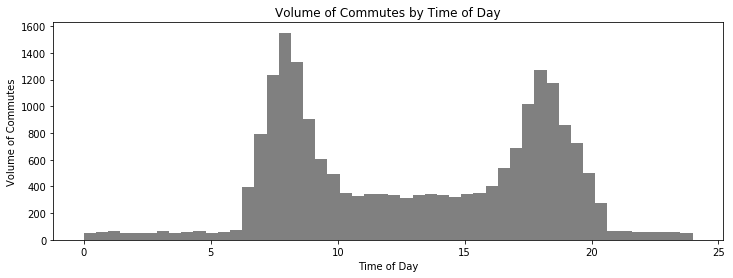

In [61]:
fig, ax = plt.subplots(figsize=(12, 4))
train_data_raw['time_of_day'].plot(
    ax=ax, kind='hist', bins=50, color='grey')
ax.set_title("Volume of Commutes by Time of Day")
ax.set_xlabel("Time of Day")
ax.set_ylabel("Volume of Commutes")

**Discussion**

We would expect high volume times to have longer commutes.  Plotting the commute time by the time of day may give some insight into the situation.

In [ ]:

# x will be the left hand edge of the bars.# x will 
x = np.arange(len(record_counts['genre']))

fig, ax = plt.subplots()

bars = ax.bar(x, record_counts['count'])
# Make the ticks at the center of the bar using:
#   center = left_edge + 0.5*width
ax.set_xticks(x)
ax.set_xticklabels(record_counts['genre'])

# Create indicator variables for each transportation type.

KeyboardInterrupt: 

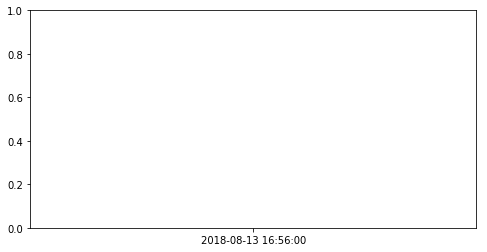

In [25]:
def convert_to_numeric(catagorical):
    classes = catagorical.unique()
    classes_mapping = {cls: i for i, cls in enumerate(classes)}
    classes_inv_mapping = {i: cls for i, cls in enumerate(classes)}
    classes_numeric = catagorical.apply(lambda cls: classes_mapping[cls])
    return classes_numeric, classes_inv_mapping

fig, ax = plt.subplots(figsize=(6, 6))

catagorical = balance_non_zero["Student"]
y = balance_non_zero['Balance']

numeric, classes_mapping = convert_to_numeric(catagorical)

noise = np.random.uniform(-0.3, 0.3, size=len(catagorical))
ax.scatter(numeric + noise, y, color="grey", alpha=0.5)

box_data = list(y.groupby(catagorical))
ax.boxplot([data for _, data in box_data], positions=range(len(box_data)))
ax.set_xticks(list(classes_mapping))
ax.set_xticklabels(list(catagorical.unique()))

ax.set_xlabel("Student?")
ax.set_ylabel("Balance")
ax.set_title("Univariate Effect of Student? on Bank Balance")